# Importing Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import seaborn as sb

# Settings

In [5]:
data_dir = '../Data/'
data_file = 'BPL_data.csv'

selected_features = ['BGAPCShallowRFU'] #, 'ChlRFUShallow','TurbShallowField','PAR_normalized_day','CO2Shallow','Month']
model_name = 'Chl_PC' # chl_chl, chl_ML, chl_FC 

# Reading external data

In [6]:
## date should be parsed as datetime in order to automatically sort in dataframes, and this is important because of working with time-series
df = pd.read_csv(data_dir + data_file, skiprows=[1], parse_dates=[['Date', 'Time']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Creating buoy (in-vivo) dataframe

In [7]:
## drop the measurements not coming with buoy data as well as rows from other datasets
df_buoy = df[df['Dataset'] == 'Buoy'].drop(['SampleID','Dataset','SiteNumber','latitude','Longitude','BottomDepth','sampledepth','SecchiDiskDepth','SamplingInScum','Lab_Chla','TSS','PARExtinction','TurbidityLab','DOC','Lab_chlaOutlier','biomassCyanobacteria','biomassChlorophyte','biomassEuglenophyte','biomassChrysophyte','biomassDiatom','biomassCryptophyte','biomassDinoflagellate','biomassTotal','Cyanobacteria','Chlorophyte','Euglenophyte','Chrysophyte','Diatom','Cryptophyte','Dinoflagellate','cellcountTotal','Bluegreen_Anabaena','Bluegreen_AgmenellumMerismopedia','Bluegreen_Anacystis','Bluegreen_Gomphosphaeria','Bluegreen_Oscillatoria','Bluegreen_Aphanizomenon','Green_Chlorella','Green_Clostrium','Green_Scenedesmus','Green_Ankistrodesmus','Green_Oocystis','Green_Chodetella','Green_Botryococcus','Green_Mougeotia','Green_Phytoconis','Green_Sphaerocystis','Green_Spirogyra','Green_Tetraedron','Green_Polyedriopsis','Green_Ulothrix','Green_Pediastrum','Green_Schroderia','Diatom_Cyclotella','Diatom_Synedra','Diatom_Cocconeis','Diatom_Nitzchia','Diatom_Navicula','Diatom_Fragillaria','Diatom_Tabellaria','Diatom_Gomphenema','Diatom_Astrionella','Flagellates','Other'], axis=1)

# Creating lab (in-vitro) dataframe

In [8]:
df_lab = df[df['Dataset'] != 'Buoy'][['Date_Time','Dataset','SiteNumber','Lab_Chla','sampledepth','Lab_chlaOutlier','latitude','Longitude']]

# taxonomy analysis and graph production

In [9]:
# filt_dataset = (df['Dataset'] != 'Buoy')
# df_lab_test = df[filt_dataset] 
# df_lab_test_ave = df_lab_test.groupby(df_lab_test.Date_Time.dt.date).agg('mean')
# df_lab_test_ave.dropna(subset = ["biomassCyanobacteria"], inplace=True) 

# df_lab_test.dropna(subset = ["biomassCyanobacteria"], inplace=True) 

# df_lab_test_ave = df_lab_test_ave.reset_index()
# df_lab_test_ave.Date_Time = pd.to_datetime(df_lab_test_ave.Date_Time)


# for year in range (2015,2019):   
#     cyano = df_lab_test_ave[df_lab_test_ave.Date_Time.dt.year==year]['biomassCyanobacteria']
#     total = df_lab_test_ave[df_lab_test_ave.Date_Time.dt.year==year]['biomassTotal']
#     plt.plot(df_lab_test_ave.Date_Time[df_lab_test_ave.Date_Time.dt.year==year].dt.dayofyear, cyano/total,  label=year)
# #     plt.xticks(df_lab_test.Date_Time[df_lab_test.Date_Time.dt.year==year])
#     plt.xlim(100,350)

    
# plt.hlines(y=.5, xmin=100, xmax=350, colors='grey', linestyles='--', lw=2, label='y = 0.5')
# plt.legend(loc="upper right")
# plt.xlabel('Day of year')
# plt.ylabel('cyanobacteria / phytoplankton')
# plt.savefig('fig_taxanomy.png', dpi=500, bbox_inches = 'tight')

# Preparing lab dataset

some outliers in lab chla data can be detected in time-series along with other chla observations. we did that manually and list outliers as a column in dataset.

In [10]:
# drop the lab observations detected as outliers 
df_lab.drop(df_lab[df_lab['Lab_chlaOutlier'] == 1].index, axis=0, inplace=True)
# drop the associated column 
df_lab.drop('Lab_chlaOutlier', axis=1, inplace=True)

In [11]:
# drop observations with nan values as chla_lab 
df_lab.dropna(subset= ['Lab_Chla'], axis=0, inplace=True)

In [12]:
#exclude lab data from stations 5-16
df_lab = df_lab[df_lab['SiteNumber'] < 5]

<AxesSubplot:>

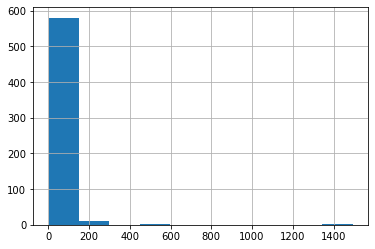

In [13]:
df_lab.Lab_Chla.hist()

Although we see some outliers maybe due to dense scum, there is nothing to worry about because these values will not affect average of daily lab measurements because of using median instead of mean. in almost all cases we have same day measurents in deep water when we have surface measurements.

In [14]:
# Averaging lab_chla over whole day
df_lab_ave = df_lab.groupby(df_lab.Date_Time.dt.date).agg({'Lab_Chla': 'median'})  # , 'Dataset': 'sum'

array([[<AxesSubplot:title={'center':'Lab_Chla'}>]], dtype=object)

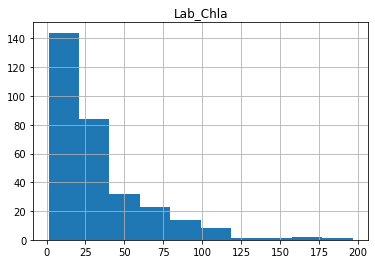

In [15]:
df_lab_ave.hist()

we log-transform our target values to have normal distribution

In [16]:
# log-transformation of chla lab
df_lab_ave_logTrans = np.log10(df_lab_ave)

In [17]:
# removing outliers lie in >3*sigma
Lab_chla_outlier = abs(df_lab_ave_logTrans.Lab_Chla - df_lab_ave_logTrans.Lab_Chla.mean()) > 3 * df_lab_ave_logTrans.Lab_Chla.std()
df_lab_ave_logTrans.drop(df_lab_ave_logTrans[Lab_chla_outlier]. index, axis=0, inplace=True)
df_lab_ave_logTrans.shape

(309, 1)

# Preparing Buoy dataset

In [18]:
# drop the buoy observations associated with biofouling error
df_buoy.drop(df_buoy[df_buoy['shallow_sonde_biofouling_outlier'] == 1].index, axis=0, inplace=True)
# drop the associated column 
df_buoy.drop('shallow_sonde_biofouling_outlier', axis=1, inplace=True)
df_buoy.reset_index(drop=True, inplace=True)

In [19]:
##Adding 'isDaylight' variable to determine whether each observation was made in day or night 
import astral
from astral import LocationInfo
from astral.sun import sun
import pytz
from datetime import datetime

# function for calculating sunset and sunrise
utc = pytz.UTC
def suntimes(date):
    loc = LocationInfo('BPL', 'Canada', 'america/regina', 50.586139, -105.384833)
    sun_times = sun(loc.observer, date, tzinfo=loc.timezone)
    return sun_times

sun_times = df_buoy.Date_Time.dt.date.apply(suntimes)
df_sun_times= pd.DataFrame(sun_times.tolist())
df_buoy['isDaylight'] = (df_buoy['Date_Time'] > df_sun_times['sunrise'].dt.tz_localize(None)) & (df_buoy['Date_Time'] < df_sun_times['sunset'].dt.tz_localize(None))

Check the type of features to see if all are numerical

In [20]:
# exploring data types in df_buoy
df_buoy.dtypes

Date_Time             datetime64[ns]
Bat                          float64
WindDir                      float64
WindSp                       float64
AirTemp                      float64
RelativeHum                  float64
BarometricPress               object
DailyRain                    float64
PARAirFlags                  float64
PARW1                        float64
PARW2                        float64
CDOM                         float64
CDOMmV                       float64
CO2Shallow                   float64
CO2Deep                      float64
TempShallow                  float64
SpCondShallow                float64
pHShallow                    float64
pHmVShallow                  float64
TurbShallowField             float64
ChlorophyllShallow           float64
ChlRFUShallow                float64
BGAPCShallow                 float64
BGAPCShallowRFU              float64
ODOSatShallow                float64
ODOShallow                   float64
TempDeep                     float64
S

In [21]:
# Extract date elements as seperate features
df_buoy['Year'] = df_buoy.Date_Time.dt.year
df_buoy['Month'] = df_buoy.Date_Time.dt.month
df_buoy['Day'] = df_buoy.Date_Time.dt.day
df_buoy['doy'] = df_buoy.Date_Time.dt.dayofyear
# put 'Date_Time' as the index of dataframe
df_buoy.index = df_buoy["Date_Time"]
# drop 'Date_Time column from the dataframe'
df_buoy.drop('Date_Time', axis=1, inplace=True)

In [22]:
## first, creating a heat map to see the relation between parameters
# correlation_matrix = df_buoy.corr().round(2)  # it seems that this function is working even with nan values in data
# plt.figure(figsize=(18,18))
# sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

from the above heat map we can see that some adjacent parameters have very high correlation, and based on our knowledge we know that these are not a seperate observation, but just a calculated parameters based on calibration factors. the reason that their correaltion with the original parameter (e.g. 'BGAPCShallow' and 'BGAPCShallowRFU' is not 1 is because the calibration factors are computed for each year (different year by year) and above correlation is four all years). So for feature reduction I decided to eliminate these calculated features in further analyses. 

In [23]:
# drop the features which are not independent measurements (except ChlorophyllShallow which I need for further analysis)
df_buoy.drop(['BGAPCDeep', 'BGAPCShallow', 'pHDeep', 'pHShallow', 'ODOSatDeep'], axis = 1, inplace=True)

# Imputing missing buoy data

In [24]:
# what percentage of each parameter is recorded as missing values
df_buoy.isnull().sum() / len(df_buoy)

Bat                   0.030557
WindDir               0.102965
WindSp                0.102979
AirTemp               0.074043
RelativeHum           0.070205
BarometricPress       0.069104
DailyRain             0.069104
PARAirFlags           0.038449
PARW1                 0.238634
PARW2                 0.125574
CDOM                  0.444101
CDOMmV                0.444031
CO2Shallow            0.379269
CO2Deep               0.980253
TempShallow           0.050024
SpCondShallow         0.050711
pHmVShallow           0.049960
TurbShallowField      0.066060
ChlorophyllShallow    0.052268
ChlRFUShallow         0.051763
BGAPCShallowRFU       0.053005
ODOSatShallow         0.634522
ODOShallow            0.119906
TempDeep              0.152378
SpCondDeep            0.155486
TDSDeep               0.962709
pHmVDeep              0.220444
BGAPCDeepRFU          0.305353
TAL PC RFU            0.876916
ODODeep               0.303740
Temp00                0.234201
Temp01                0.177492
Temp02  

In [25]:
# drop the unrelated parameters to chla (based on my judgement) and features with more than %50 of data stored as nan
df_buoy = df_buoy.drop(['Bat', 'CO2Deep', 'ODOSatShallow', 'CDOM', 'CDOMmV'], axis=1).copy()
df_buoy.isnull().sum()

WindDir                14678
WindSp                 14680
AirTemp                10555
RelativeHum            10008
BarometricPress         9851
DailyRain               9851
PARAirFlags             5481
PARW1                  34018
PARW2                  17901
CO2Shallow             54066
TempShallow             7131
SpCondShallow           7229
pHmVShallow             7122
TurbShallowField        9417
ChlorophyllShallow      7451
ChlRFUShallow           7379
BGAPCShallowRFU         7556
ODOShallow             17093
TempDeep               21722
SpCondDeep             22165
TDSDeep               137237
pHmVDeep               31425
BGAPCDeepRFU           43529
TAL PC RFU            125007
ODODeep                43299
Temp00                 33386
Temp01                 25302
Temp02                 25278
Temp03                 25258
Temp04                 33454
isDaylight                 0
Year                       0
Month                      0
Day                        0
doy           

In [26]:
## plot all features to see the time distribution of missing values to select the best approach to impute missing values
# plt.figure(figsize = [18 , 56])
# myFmt = mdates.DateFormatter('%m')
# years = df_buoy['Year'].unique()
# features = df_buoy.columns
# i = 0
# for feature in features[:-3]:  # to not include day, month and year features
#     for year in years:
#         i += 1
#         ax = plt.subplot(len(features), len(years), i)
#         filt_year = df_buoy['Year'] == year
#         ax.plot(df_buoy[filt_year][feature]) # the x-axis is the index
#         ax.xaxis.set_major_formatter(myFmt)
#         ax.text(.2, .8, str(df_buoy[filt_year][feature].isnull().sum()), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)
#         if year == 2014:
#             plt.ylabel(feature)

In [27]:
# # plot again the heatmap
# correlation_matrix = df_buoy.corr().round(2)  # it seems that this function is working even with nan values in data
# plt.figure(figsize=(18,18))
# sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

In [28]:
# create a new dataframe for imputed data
imputed_df_buoy = df_buoy.copy()

the reason to connect each year to the next one in some cases is that , the two points in two successive years are connected to each other before imputing if both exist (non-missing). if one of them are missing (e.g. the lst measuremt in the previous year or the first measuremtn in the later year are missing) the line is not connected in it will be connected after impution of the missing value in impution algorithm.

for wind direction I think a median or mean method over month makes more sense than interpolation because the missing values are suucessive in most cases which make interpolation hard. Also it seems there is a relation between these two parameters and month in plot a couple of lines above. I chose median over mean because I think median makes more sense for direction. form a wind_rose for BPL I saw the wind direction is more in a same direction. 

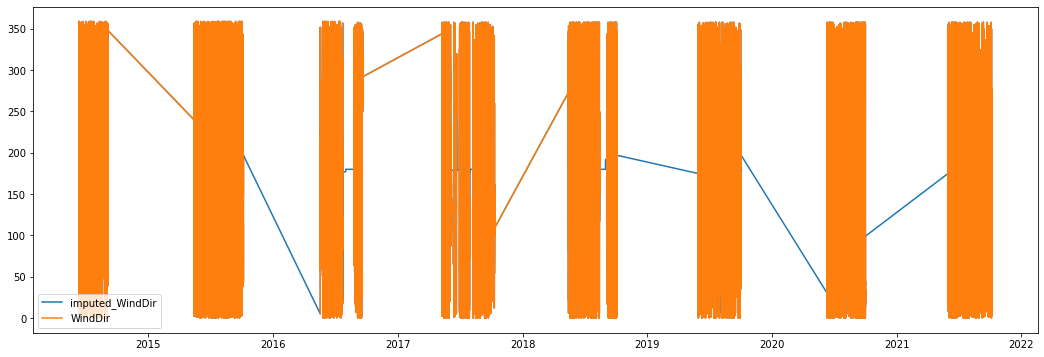

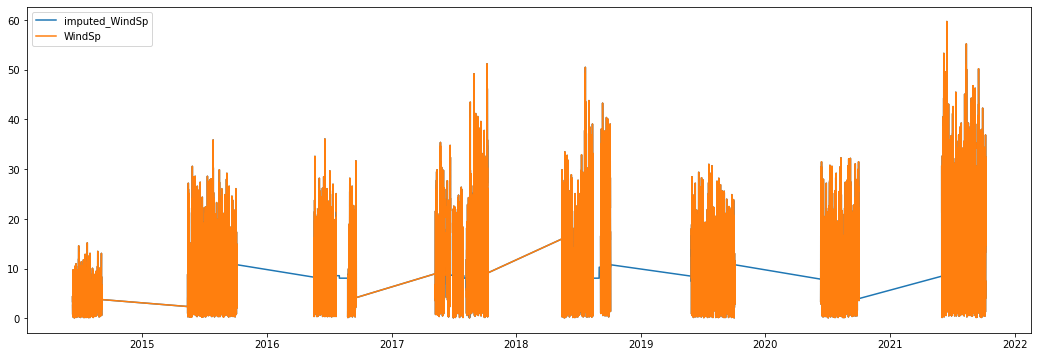

In [29]:
# impute winddir and windspeed based on median over month
imputed_df_buoy.WindDir = df_buoy.WindDir.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.median()))
imputed_df_buoy.WindSp = df_buoy.WindSp.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.median()))

plt.figure(figsize = [18 , 6])
plt.plot(imputed_df_buoy.WindDir)
plt.plot(df_buoy.WindDir)
plt.legend(['imputed_WindDir' , 'WindDir'])

plt.figure(figsize = [18 , 6])
plt.plot(imputed_df_buoy.WindSp)
plt.plot(df_buoy.WindSp)
plt.legend(['imputed_WindSp' , 'WindSp'])

for these parameters below, it seems a monthly mean or median would be enough, based on their pattern, number and succesive of mising values, their nature, and the correlation with other parameters.

In [30]:
# impute some parameters based on mean or median over month
imputed_df_buoy.AirTemp = df_buoy.AirTemp.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))
imputed_df_buoy.RelativeHum = df_buoy.RelativeHum.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))
# imputed_df_buoy.BarometricPress = df_buoy.BarometricPress.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))
imputed_df_buoy.DailyRain = df_buoy.DailyRain.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.median()))
imputed_df_buoy.PARAirFlags = df_buoy.PARAirFlags.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.median()))

I dont know yet how to deal with CO2shallow, so keep it simple for now

In [31]:
imputed_df_buoy.CO2Shallow = df_buoy.CO2Shallow.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))

Tempshallow can be estimated from Airtemp, but the number of missing values are few, so keep it simple

In [32]:
imputed_df_buoy.TempShallow = df_buoy.TempShallow.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))

maybe the best option?

In [33]:
# impute with interpolation with 'time' method
imputed_df_buoy.SpCondShallow = df_buoy.SpCondShallow.interpolate(method='time')
imputed_df_buoy.pHmVShallow = df_buoy.pHmVShallow.interpolate(method='time')
imputed_df_buoy.ChlRFUShallow = df_buoy.ChlRFUShallow.interpolate(method='time')
imputed_df_buoy.BGAPCShallowRFU = df_buoy.BGAPCShallowRFU.interpolate(method='time')
imputed_df_buoy.ChlorophyllShallow = df_buoy.ChlorophyllShallow.interpolate(method='time')

I dont know yet how to deal with ODOShallow, so keep it simple for now

In [34]:
imputed_df_buoy.ODOShallow = df_buoy.ODOShallow.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))

I know that interpolation is not good for features below because there is suucessive misssig data. and maybe the best method is to corrolate with shallow sensor for each parameter but method below is just for simplicity. 

<AxesSubplot:>

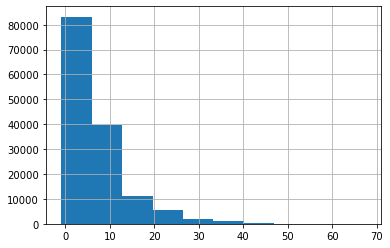

In [35]:
#Create a Linear Regression model to estimate the missing data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_buoy[['BGAPCDeepRFU', 'BGAPCShallowRFU']])
imputed_df_buoy['BGAPCDeepRFU'] = imp.transform(df_buoy[['BGAPCDeepRFU', 'BGAPCShallowRFU']])
imputed_df_buoy['BGAPCDeepRFU'].hist()

In [36]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['TurbShallowField'] = imp.fit_transform(df_buoy[['TurbShallowField', 'BGAPCShallowRFU']])
imputed_df_buoy['TurbShallowField'].describe()

count    142553.000000
mean          9.867369
std          15.482931
min          -0.200000
25%           4.300000
50%           7.200000
75%          11.700000
max         981.400000
Name: TurbShallowField, dtype: float64

In [37]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['TempDeep'] = imp.fit_transform(df_buoy[['TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [38]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['Temp00'] = imp.fit_transform(df_buoy[['Temp00', 'TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [39]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['Temp01'] = imp.fit_transform(df_buoy[['Temp01', 'Temp00', 'TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [40]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['Temp02'] = imp.fit_transform(df_buoy[['Temp02', 'Temp01', 'Temp00', 'TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [41]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['Temp03'] = imp.fit_transform(df_buoy[['Temp03', 'Temp02', 'Temp01', 'Temp00', 'TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [42]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['Temp04'] = imp.fit_transform(df_buoy[['Temp04', 'Temp03', 'Temp02', 'Temp01', 'Temp00', 'TempDeep', 'TempShallow', 'AirTemp']])

C:\Users\amirc\miniconda3\envs\p1\lib\site-packages\sklearn\impute\_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


for PARW1 & PARW2, it seems that an ML model to predict it based on PARAirFlags and some water parameters would be the best method because of its good corelation with other parameters, having missing values for whole a year. however, for now just keep it as simple as I can with a monthly average.

In [43]:
#Create a Linear Regression model to estimate the missing data
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_df_buoy['PARW1'] = imp.fit_transform(df_buoy[['PARW1','PARAirFlags']])
imputed_df_buoy['PARW2'] = imp.fit_transform(df_buoy[['PARW1','PARAirFlags']])

In [44]:
imputed_df_buoy.SpCondDeep = df_buoy.SpCondDeep.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))
imputed_df_buoy.pHmVDeep = df_buoy.pHmVDeep.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))
imputed_df_buoy.ODODeep = df_buoy.ODODeep.groupby(df_buoy.Month).transform(lambda x: x.fillna(x.mean()))

In [45]:
imputed_df_buoy.isnull().sum()

WindDir                    0
WindSp                     0
AirTemp                    0
RelativeHum                0
BarometricPress         9851
DailyRain                  0
PARAirFlags                0
PARW1                      0
PARW2                      0
CO2Shallow                 0
TempShallow                0
SpCondShallow              0
pHmVShallow                0
TurbShallowField           0
ChlorophyllShallow         0
ChlRFUShallow              0
BGAPCShallowRFU            0
ODOShallow                 0
TempDeep                   0
SpCondDeep                 0
TDSDeep               137237
pHmVDeep                   0
BGAPCDeepRFU               0
TAL PC RFU            125007
ODODeep                    0
Temp00                     0
Temp01                     0
Temp02                     0
Temp03                     0
Temp04                     0
isDaylight                 0
Year                       0
Month                      0
Day                        0
doy           

# averaging buoy data on a daily basis

In [46]:
# Averaging buoy data over whole day
df_buoy_ave = imputed_df_buoy.groupby(imputed_df_buoy.index.date).agg('median')

# Feature Generation

In [47]:
## Creating some daily parameters
filt_day = imputed_df_buoy['isDaylight'] == True
df_buoy_ave['PARW1_day'] = imputed_df_buoy[filt_day]['PARW1'].groupby(imputed_df_buoy[filt_day].index.date).agg('mean')
df_buoy_ave['PARAirFlags_day'] = imputed_df_buoy[filt_day]['PARAirFlags'].groupby(imputed_df_buoy[filt_day].index.date).agg('mean')
df_buoy_ave['PAR_normalized_day'] = df_buoy_ave['PARW1_day']/df_buoy_ave['PARAirFlags_day']

## Creating some nightly parameters
df_buoy_ave['BGAPCShallowRFU_night'] = imputed_df_buoy[~filt_day]['BGAPCShallowRFU'].groupby(imputed_df_buoy[~filt_day].index.date).agg('median')
df_buoy_ave['ChlRFUShallow_night'] = imputed_df_buoy[~filt_day]['ChlRFUShallow'].groupby(imputed_df_buoy[~filt_day].index.date).agg('median')
df_buoy_ave['ChlorophyllShallow_night'] = imputed_df_buoy[~filt_day]['ChlorophyllShallow'].groupby(imputed_df_buoy[~filt_day].index.date).agg('median')

## creating parameters with time lag based on averaging window
df_buoy_ave['TempShallow_SMA3'] = df_buoy_ave['TempShallow'].rolling(window=3).mean()
df_buoy_ave['TempShallow_SMA3'] = df_buoy_ave['TempShallow_SMA3'].groupby(df_buoy_ave.Month).transform(lambda x: x.fillna(x.median()))

df_buoy_ave['WindSp_SMA3'] = df_buoy_ave['WindSp'].rolling(window=3).mean()
df_buoy_ave['WindSp_SMA3'] = df_buoy_ave['WindSp_SMA3'].groupby(df_buoy_ave.Month).transform(lambda x: x.fillna(x.median()))

df_buoy_ave['PARAirFlags_day_SMA3'] = df_buoy_ave['PARAirFlags_day'].rolling(window=3).mean()
df_buoy_ave['PARAirFlags_day_SMA3'] = df_buoy_ave['PARAirFlags_day_SMA3'].groupby(df_buoy_ave.Month).transform(lambda x: x.fillna(x.median()))

df_buoy_ave['PAR_normalized_day_SMA3'] = df_buoy_ave['PAR_normalized_day'].rolling(window=3).mean()
df_buoy_ave['PAR_normalized_day_SMA3'] = df_buoy_ave['PAR_normalized_day_SMA3'].groupby(df_buoy_ave.Month).transform(lambda x: x.fillna(x.median()))

# ## creating parameters with 
# df_buoy_ave['stratification'] = df_buoy_ave['Temp04'] - df_buoy_ave['Temp00']
# #df_buoy_ave['stratification'] = df_buoy_ave['TempShallow'] - df_buoy_ave['TempDeep']

# df_buoy_ave['BGAPCShallowRFU_t-1'] = df_buoy_ave['BGAPCShallowRFU'] - df_buoy_ave['BGAPCShallowRFU'].shift(-1) 
# df_buoy_ave['BGAPCShallowRFU_t+1'] = df_buoy_ave['BGAPCShallowRFU'].shift(+1) - df_buoy_ave['BGAPCShallowRFU']

# Merging lab and buoy datasets

In [48]:
## inner merging both dataframes to extract coincidence dates in which we have both lab and buoy data
df_both = pd.merge(df_lab_ave_logTrans, df_buoy_ave, left_index=True, right_index=True, how='inner')

In [49]:
# # plot the heatmap to see the correaltion of buoy parameters with lab chla
# correlation_matrix = df_both.corr().round(2)  # it seems that this function is working even with nan values in data
# plt.figure(figsize=(18,18))
# sb.heatmap(data=correlation_matrix, annot=True, center=0.0, cmap='coolwarm')

among PARs I think it makes more sense to use AirPAR because it just depends on PAR but the other ones also depends on chla and turbidity which can be catch by better features like the one below which only depends on turbidity and chla not AIRPAR.

# Some extra analysis

Now, some analysis to show the relation of paraemters (especially generated ones) with chla. This shows what other works (studies) we can do with this dataset.

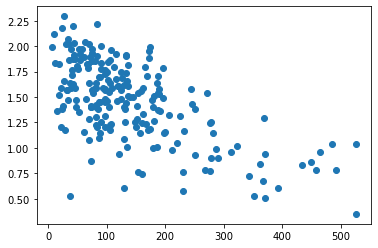

In [50]:
plt.scatter(df_both.PARW1_day, df_both.Lab_Chla)
# could also be:
#plt.scatter(df_buoy_ave.PARW1_day, df_buoy_ave.BGAPCShallowRFU)

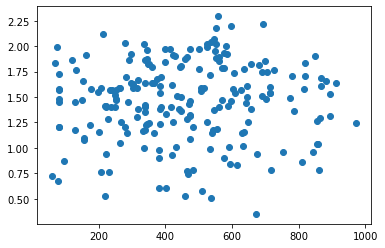

In [51]:
plt.scatter(df_both.PARAirFlags_day, df_both.Lab_Chla)

array([[ 1.        , -0.65809697],
       [-0.65809697,  1.        ]])

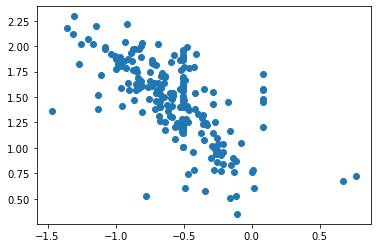

In [52]:
plt.scatter(np.log10(df_both.PAR_normalized_day), df_both.Lab_Chla)
np.corrcoef(np.log10(df_both.PAR_normalized_day), df_both.Lab_Chla)

array([[ 1.        , -0.63618615],
       [-0.63618615,  1.        ]])

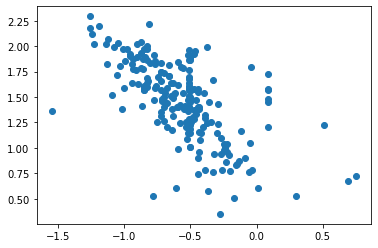

In [53]:
plt.scatter(np.log10(df_both.PAR_normalized_day_SMA3), df_both.Lab_Chla)
np.corrcoef(np.log10(df_both.PAR_normalized_day_SMA3), df_both.Lab_Chla)

another feature to generate could be a combination of temp in depths to show thestratification

# Feature Preparation

In [54]:
# # Exporting processed data to file
# df_both.to_csv('BuoyLabData_SameDay.csv')

# # Importing processed data from file
# df_both = pd.read_csv('BuoyLabData_SameDay.csv')

In [55]:
# extract target as y from data
y = df_both['Lab_Chla']
X = df_both.drop(['Lab_Chla'], axis=1)
y.describe()

count    212.000000
mean       1.456144
std        0.389047
min        0.350248
25%        1.206149
50%        1.494404
75%        1.748308
max        2.294031
Name: Lab_Chla, dtype: float64

array([[<AxesSubplot:title={'center':'BGAPCShallowRFU'}>]], dtype=object)

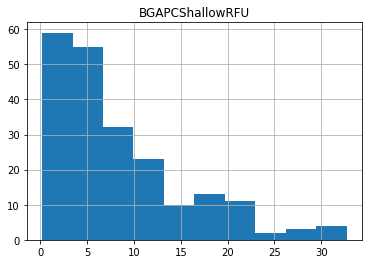

In [56]:
## a manual feature selection based on correlation with chla_lab and feature redundancy
X_sel = X[selected_features]
X_sel.hist()

In [57]:
# # in case we have categorical features

# cat_col = selected_features.pop(-1)
# num_cal = selected_features.copy()

# from sklearn.preprocessing import OrdinalEncoder

# encoder = OrdinalEncoder()
# new_col = encoder.fit_transform(np.array(X_sel[cat_col]).reshape(-1,1))

array([[<AxesSubplot:title={'center':'BGAPCShallowRFU'}>]], dtype=object)

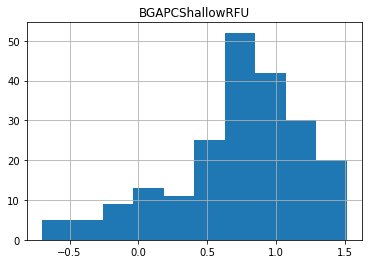

In [58]:
# log-transform features because they all seem having log-normal distribution
X_sel_logTrans = X_sel.copy()
for feature in selected_features:
    if np.min(X_sel[feature]) > 0:
        X_sel_logTrans[feature] = pd.DataFrame(np.log10(X_sel[feature]))
    elif np.max(X_sel[feature]) < 0:
        X_sel_logTrans[feature] = pd.DataFrame(np.log10(abs(X_sel[feature])))
    elif np.min(X_sel[feature]) == 0:
        X_sel_logTrans[feature] = pd.DataFrame(np.log1p(X_sel[feature]))
        
X_sel_logTrans.hist()

array([[<AxesSubplot:title={'center':'BGAPCShallowRFU'}>]], dtype=object)

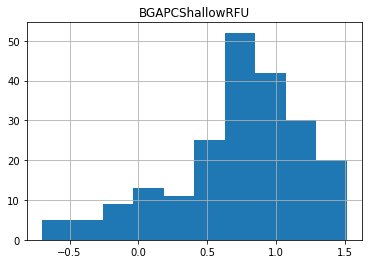

In [59]:
# detect outliers and replace with median value
def reject_outliers(feature, m):
    return abs(feature - np.median(feature)) > m * np.std(feature)

features = X_sel_logTrans.copy()
for feature in features:
    idx_outlier = reject_outliers(features[feature], 3.5)
    features[feature][idx_outlier] = features[feature].median()

X_sel_logTrans = features.copy()
X_sel_logTrans.hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

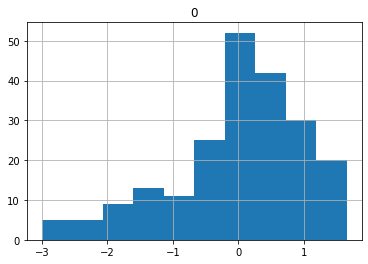

In [111]:
# normalize features             IT seems that normalizing is not needed at least for PC single-feature model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sel_logTrans_normalized = scaler.fit_transform(X_sel_logTrans)
pd.DataFrame(X_sel_logTrans_normalized).hist()

## Model Development

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.neural_network import MLPRegressor

model = LinearRegression()
#model = PLSRegression(n_components =3)
#model = MLPRegressor(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000, random_state=0)

In [62]:
## ANOVA SVM-C
# # 1) anova filter, take 3 best ranked features
# anova_filter = SelectKBest(f_regression, k=6)
# anova_filter

In [98]:
# create a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_degree = 1
poly_featureGenerator = PolynomialFeatures(degree = poly_degree, interaction_only=False, include_bias=True, order='C')

my_pipeline = Pipeline(steps=[('poly_transform', poly_featureGenerator), ('model', model)])#('filter', anova_filter),

In [112]:
# cross validation and accuracy assessment of model
from sklearn.model_selection import cross_val_score
mae = 10**(-1 * cross_val_score(my_pipeline,X_sel_logTrans_normalized, y, cv=5, scoring='neg_mean_absolute_error').mean())
mae

1.389173116913434

In [65]:
# getting predictions values from cross validation
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(my_pipeline, X_sel_logTrans_normalized, y, cv=5)

# Save results and model into drive

In [116]:
import joblib

# save model for further use
model.fit(X_sel_logTrans, y)
joblib.dump(model, 'BuoyCalibrationModel_' + model_name + '.joblib')

# # save a csv file containing pred_chla and lab_chla for further analysis
# y_pred_df = pd.Series(y_pred, index = y.index, name = 'chla_pred') # X.ChlorophyllShallow 
# pd.DataFrame(pd.concat([y, y_pred_df],axis=1)).to_csv(model_name + '.csv')

['BuoyCalibrationModel_Chl_PC.joblib']

# ANOVA test

In [67]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# data_for_statsmodels = pd.concat([y, pd.DataFrame(X_sel_logTrans, columns=selected_features, index = X.index)], axis = 1)

# # mod2 = ols('Lab_Chla ~ TurbShallowField + PAR_normalized_day + CO2Shallow + Month ', data = data_for_statsmodels).fit()
# mod2 = ols('Lab_Chla ~ BGAPCShallowRFU + ChlRFUShallow ', data = data_for_statsmodels).fit()
# #mod1 = ols('Lab_Chla ~ BGAPCShallowRFU', data = data_for_statsmodels).fit()
# #sm.stats.anova_lm(mod1, mod2)
# results = sm.stats.anova_lm(mod2, type=2)
# # mod2.summary()
# #round(results,2)
# results

## correlation plot for paper

In [68]:
# # Creating correlation plot for fuorometry paper
# for_corr = data_for_statsmodels.copy()
# for_corr.drop(['Month'],axis=1,inplace=True)

# # for_corr.rename(columns = {'Lab_Chla': '$chl_{M}$', 'TurbShallowField': 'turbidity', 'PAR_normalized_day':'nPAR$_{water}$',  'CO2Shallow':'CO$_{2}$'}, inplace=True)
# for_corr.rename(columns = {'Lab_Chla': '$chl_{M}$', 'BGAPCShallowRFU': 'PC fluorescence', 'ChlRFUShallow':'Chl-a fluorescence'}, inplace=True)

# correlation_matrix = for_corr.corr().round(2)  # it seems that this function is working even with nan values in data
# plt.figure(figsize=(5,5))
# g = sb.heatmap(data=correlation_matrix, annot=True,center=0.0, cmap='coolwarm')
# sb.set(font_scale=1)
# g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 13)
# g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 13)
# plt.xticks(rotation=90) 
# plt.savefig('fig8.png', dpi=500, bbox_inches = 'tight')

# Time series of chla data from calibrated buoy data

In [69]:
# scaler = StandardScaler()
# df_buoy_ave_sel_logTrans_normalized = scaler.fit_transform(np.log10(df_buoy_ave[selected_features]))

# model.fit(X_sel_logTrans_normalized, y)
# df_buoy_ave['pred_val_chl'] = model.predict(df_buoy_ave_sel_logTrans_normalized)
# plt.plot(10**y_pred)

# df_buoy_ave[['pred_val_PC','pred_val_ML', 'pred_val_chl']].to_csv('pred_values.csv')
# df_both[['Lab_Chla','ChlRFUShallow','BGAPCShallowRFU']].to_csv('df_both.csv')
# # df[['Date_Time', 'ChlorophyllShallow','Dataset']].to_csv('df.csv')
# # df_lab[['Date_Time','Lab_Chla', 'Dataset', 'sampledepth']].to_csv('df_lab.csv')

# Creating Reliability graph for paper

we provide info for this figure from two seperate dataframes

In [70]:
# # exclude surface samples from this analyis
# filt_sampledepth = df_lab['sampledepth'] != 0

# # grouping based on date and dataset
# df_lab_ave_date_dataset = (df_lab[filt_sampledepth]).groupby([df_lab.Date_Time.dt.date,'Dataset']).agg({'Lab_Chla': 'median'}) 

# # log-transform to normal distribution
# df_lab_ave_date_dataset['Lab_Chla'] = np.log10(df_lab_ave_date_dataset['Lab_Chla'])

# #  get rid of individual observations in one day
# df_lab_ave_date_dataset = df_lab_ave_date_dataset[df_lab_ave_date_dataset.index.get_level_values('Date_Time').duplicated(keep=False)]

# df_lab_ave_date_dataset['Dataset'] = df_lab_ave_date_dataset.index.get_level_values('Dataset')

# df_lab_ave_date_dataset = df_lab_ave_date_dataset.droplevel(1).copy()

# # inner merge both dataframe
# df_lab_ave_date_dataset = pd.merge(df_lab_ave_date_dataset, y_pred_df, left_index=True, right_index=True, how='inner')

# df_lab_ave_date_dataset_par = df_lab_ave_date_dataset.groupby([df_lab_ave_date_dataset.index]).agg({'Lab_Chla': ['mean','std']})

# # inner merge both dataframe
# df_both_pred_lab = pd.merge(df_lab_ave_date_dataset_par, pd.DataFrame(y_pred_df), left_index=True, right_index=True, how='inner')

# df_both_pred_lab.dropna(axis=0,inplace=True)

In [71]:
# import matplotlib.dates as mdates
# plt.figure(figsize=(12,7))
# df_both_pred_lab['dates']=df_both_pred_lab.index
# dates = df_both_pred_lab['dates']
# plt.scatter(dates.apply(lambda x: x.strftime('%Y-%m-%d')), df_both_pred_lab['chla_pred'], color = 'r', s = 15, label = 'chl$^{ML}_{P}$')
# plt.errorbar(dates.apply(lambda x: x.strftime('%Y-%m-%d')), df_both_pred_lab[('Lab_Chla', 'mean')], 2*df_both_pred_lab[('Lab_Chla', 'std')],  ls='none', capsize = 2, elinewidth = 1 , label = r'$\pm$' + '2*' + r'$\sigma$' + ' variation')

# df_lab_ave_date_dataset['dates'] = df_lab_ave_date_dataset.index
# dates1 = df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='Calibration']['dates']
# dates2 = df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='WTP']['dates']
# dates3 = df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='HPLC']['dates']
# dates4 = df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='Survey']['dates']

# plt.scatter(dates1.apply(lambda x: x.strftime('%Y-%m-%d')), df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='Calibration']['Lab_Chla'],  marker = '^', color = [1,0,0], s = 15, label = 'chl$_{M}$ (E)')
# plt.scatter(dates2.apply(lambda x: x.strftime('%Y-%m-%d')), df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='WTP']['Lab_Chla'],  marker = '^', color = [.8,0.4,0], s = 15, label = 'chl$_{M}$ (W)')
# plt.scatter(dates3.apply(lambda x: x.strftime('%Y-%m-%d')), df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='HPLC']['Lab_Chla'],  marker = '^', color = [.7,0,.7], s = 15, label = 'chl$_{M}$ (H)')
# plt.scatter(dates4.apply(lambda x: x.strftime('%Y-%m-%d')), df_lab_ave_date_dataset[df_lab_ave_date_dataset['Dataset']=='Survey']['Lab_Chla'],  marker = '^', color = 'black', s = 15, label = 'chl$_{M}$ (S)')

# plt.xticks(fontsize= 13 , rotation = 90)
# plt.yticks(ticks = [0, 1, 2, 2.47],labels = [1, 10, 100, 300], fontsize= 13 )
# plt.ylabel('Concentration mg/m\u00b3',fontsize= 15 )
# #plt.grid()
# #ax1.set_yscale('log')
# plt.legend(ncol=1, loc='center right', bbox_to_anchor=(1.2,.5))
# #plt.savefig('fig10.png', dpi=500, bbox_inches = 'tight')

In [72]:
# #compute reliability
# sum(abs(10**df_both_pred_lab[('Lab_Chla', 'mean')] - df_both_pred_lab['ChlorophyllShallow'])<3*10**df_both_pred_lab[('Lab_Chla', 'std')])/35